In [1]:
import json

import pandas as pd
import datetime as dt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import pyLDAvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

### Load and prepare corpus

In [2]:
pre_corpus = json.load(open('clean data/pre_corpus.json'))
post_corpus = json.load(open('clean data/post_corpus.json'))                

combined_corpus = pre_corpus + post_corpus

In [3]:
len(combined_corpus)

12334

* Get a list of article body string

In [4]:
docs = [art['body'] for art in combined_corpus]

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')
english_stop_words.extend(['vaccine', 'vaccination', 'vaccines'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2025m\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### AI/ML: Topic modeling on NYT articles

* Topic Modeling is an unsupervised machine learning technique that looks for a specified number of __TOPICS__ presumed to be the possible meaning space behind a set of documents (i.e., _in this context these are the N things people are likely to talk about_). In an iterative procedure patterns of term co-occurrence (topics) are found across documents. 

* The result is that for each document each of the N topics has a probability distribution (summing to 1) indicating the likelihood or contribution of each topic to the document. Topics are rankings of terms.

#### Steps

1. Build a DTM from the `body` text field
2. Set up a LDA model with a specified number of topics to discover
3. Run the modeling
4. Examine the topics by looking at the top ranked terms in each topic and evaluating the plausibility of them as semantic groups.
5. Use document topic distributions in analysis.

In [6]:
# STEP 1 Define DTM
article_cnt_vect = CountVectorizer(
    token_pattern="[a-z][a-z'-]+",
    stop_words=english_stop_words,
    max_df=0.7,
    min_df=10,
    max_features=5000
)

In [7]:
art_dtm = article_cnt_vect.fit_transform(docs)

In [8]:
art_dtm

<12334x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 3972875 stored elements in Compressed Sparse Row format>

* DTM is 12,334 documents and 5,000 features

In [9]:
# STEP 2
N_topics = 7
article_LDA = LatentDirichletAllocation(n_components=N_topics,
                                        max_iter=10,
                                        learning_method='online',
                                        learning_offset=1,
                                        batch_size=256,
                                        random_state=0,
                                        verbose=1)

In [10]:
tm = article_LDA.fit_transform(art_dtm)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [11]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_,1):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()

In [12]:
n_top_words=40
print("\nTopics in LDA model:\n====================\n")
tf_feature_names = article_cnt_vect.get_feature_names_out()
print_top_words(article_LDA, tf_feature_names, n_top_words)


Topics in LDA model:

Topic #1: mr trump president biden times house like white york political time republican news election first even administration party could campaign state former country republicans democrats national us ms think years many government day two get american back last americans coronavirus

Topic #2: company percent companies million billion year government could federal economy economic mr pandemic market business coronavirus drug states money last administration pfizer doses industry financial week businesses united help chief stock moderna next executive even spending unemployment congress prices may

Topic #3: care dr public medical children state school department federal like get york many patients hospital program parents doctors university need ms say work make could system government services years hospitals time mr law center workers insurance child director www think

Topic #4: virus dr disease flu coronavirus cases outbreak officials infected spread cou

To begin, we employed clustering to look for groupings among documents in the corpus and topic modeling to identify sets of co-occurring words/n-grams across documents. What you see above is 7 groupings of words that fit with the topics identified. From the analysis above, we determined the following titles for each topic: 
*  Topic 1: Politics and Administration
*  Topic 2: Pharmaceutical Industry
*  Topic 3: Health Departments
*  Topic 4: Disease Outbreak First Reponse
*  Topic 5: COVID-19 Pandemic Local Response
*  Topic 6: Aids Related 
*  Topic 7: International Reponse

#### Visualization of topic model

* The `pyLDAvis` module provides a nice interactive visualization of a topic model.

* Each topic is represented by a circle, the size of which indicates the proportion of topic representation in the corpus. The positioning in 2D space of the topic circles gives an indication of how distinct the topics are (often see some level of overlap because of shared terms).

* The bar graph on the right indicates the top 30 terms most associated with a topic.

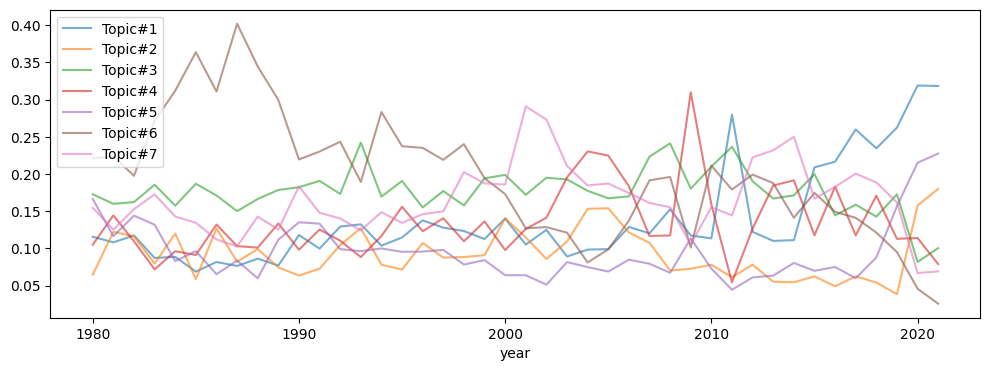

In [13]:
topic_df=pd.DataFrame(tm, columns=[f'Topic#{n}' for n in range(1,N_topics+1)])
years = [pd.to_datetime(art['pubdate']).year for art in combined_corpus]
topic_df['year']=years
topic_df.set_index('year').groupby('year').agg('mean').sort_index().plot(style='-', figsize=(12,4), alpha=0.6)
plt.show()

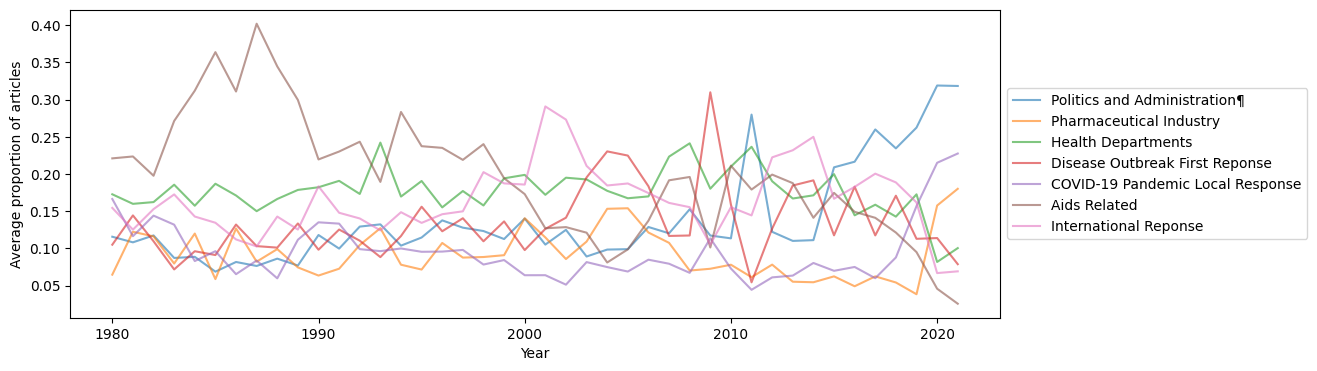

In [14]:
topic_labels_str = '''Topic 1: Politics and Administration¶
Topic 2: Pharmaceutical Industry
Topic 3: Health Departments
Topic 4: Disease Outbreak First Reponse
Topic 5: COVID-19 Pandemic Local Response
Topic 6: Aids Related
Topic 7: International Reponse'''

topic_labels = [label.strip().split(': ')[1] for label in topic_labels_str.split('\n')]
                
topic_df=pd.DataFrame(tm, columns=topic_labels)
years = [pd.to_datetime(art['pubdate']).year for art in combined_corpus]
topic_df['year']=years
ax=topic_df.set_index('year').groupby('year').agg('mean').sort_index().plot(style='-', figsize=(12,4), alpha=0.6)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('Year')
ax.set_ylabel('Average proportion of articles')
plt.show()